# Le code suivant mets en place l'étude de la recherche LSH

In [12]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from lsh import LSH
from brute_force import knn_search
from IPython.display import Image
from sklearn.neighbors import NearestNeighbors
import time

## Import de la base d'images et des images requêtes

In [13]:
base = np.load("./descripteur_img.npy")
base_name = np.load("./descripteur_img_filename.npy")

queries = np.load("./descripteur_queries.npy")
queries_name = np.load("./descripteur_queries_filename.npy")


data_size = len(base)
nb_queries=len(queries)

## Création d'une variable contenant l'algorithme par force brut qui nous servira pour obtenir des résultats de bases

In [14]:
bf = NearestNeighbors(n_neighbors=1, algorithm='brute')
bf.fit(base)

#variables contenant les résultas de la recherche du plus proche voisin de chaque image recherche par force brut
ground_results = bf.kneighbors(queries, n_neighbors=1)
ground_indices = ground_results[1]

## Déterminons la valeur optimale de W

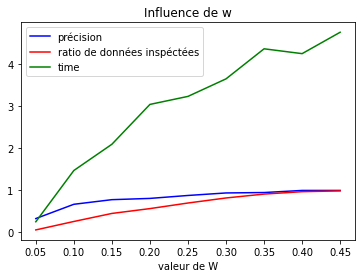

In [15]:

#valeurs de w allant de 0.005 à 0.5
w_values =[0.05*i for i in range(1,10)]

#listes contenant les caractéristiques mesurées pour chaque valeurs de W
precisions = []
ratio_avgs = []
times = []

#itération dans les valeurs de w et réalisation des recherches pour toutes les requêtes
for w in w_values:
    #création de la variable contenant la classe LSH avec un nombre de projectinos et de tables fixés
    lsh=LSH(nb_projections=10, nb_tables=2, w=w)
    lsh.fit(base)
    
    
    #variables contenant les caractéristques pour une valeur de w
    nb_rigth_ones=0
    ratio_sum=0
    
    #initialisation du temps
    start=time.time()
    
    #lancement de la recherche pour chaque image requête
    for i,query in enumerate(queries):
        lsh_result = lsh.kneighbors(query, k=1)
        lsh_index = lsh_result[1][0]
        nb_rigth_ones += 1 if lsh_index == ground_indices[i] else 0
        inspected = lsh_result[2]
        ratio = inspected/data_size
        ratio_sum+= ratio
    
    #fin de la mesure de temps
    end= time.time() 
    
    #Ajout des caractéristiques aux listes
    precision = nb_rigth_ones / nb_queries
    precisions.append(precision)
    
    ratio_avg = ratio_sum / nb_queries
    ratio_avgs.append(ratio_avg)
    
    times.append(end-start)

#Traçage des courbes montrant l'influance de W sur la recherche

# courbe de la précision en fonction de W
plt.plot(w_values, precisions, label="précision", color="blue")
# courbe du nombre de données inspectés en moyenne en fonction de W
plt.plot(w_values, ratio_avgs, label="ratio de données inspéctées", color="red")
# courbe du temps de la rechcerche en fonction de W
plt.plot(w_values, times, label="time", color="green")
plt.legend()
plt.xlabel("valeur de W")
plt.title("Influence de w")
plt.show()    

## Déterminons la valeur optimale de T(nombdre de tables) avec w = 0.15

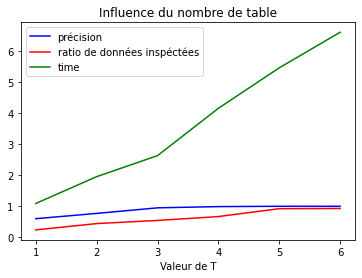

In [16]:
t_values =  [i for i in range(1,7)]

#listes contenant les caractéristiques mesurées pour chaque valeurs de W
precisions = []
ratio_avgs = []
times = []

#itération pour les valeurs de T allant de 1 à 7 et réalisation des recherches pour toutes les requêtes
for T in t_values:
    
    #création de la variable contenant la classe LSH avec un nombre de projectinos et de tables fixés
    lsh=LSH(nb_projections=10, nb_tables=T, w=0.15)
    lsh.fit(base)
    
    
    #variables contenant les caractéristques pour une valeur de T
    nb_rigth_ones=0
    ratio_sum=0
    
    #initialisation du temps
    start=time.time()
    
    #lancement de la recherche pour chaque image requête
    for i,query in enumerate(queries):
        lsh_result = lsh.kneighbors(query, k=1)
        lsh_index = lsh_result[1][0]
        nb_rigth_ones += 1 if lsh_index == ground_indices[i] else 0
        inspected = lsh_result[2]
        ratio = inspected/data_size
        ratio_sum+= ratio
    
    #fin de la mesure de temps
    end= time.time() 
    
    #Ajout des caractéristiques aux listes
    precision = nb_rigth_ones / nb_queries
    precisions.append(precision)
    
    ratio_avg = ratio_sum / nb_queries
    ratio_avgs.append(ratio_avg)
    
    times.append(end-start)

#Traçage des courbes montrant l'influance du nombre de table sur la recherche

# courbe de la précision en fonction de T
plt.plot(t_values, precisions, label="précision", color="blue")
# courbe du nombre de données inspectés en moyenne en fonction de T
plt.plot(t_values, ratio_avgs, label="ratio de données inspéctées", color="red")
# courbe du temps de la rechcerche en fonction de T
plt.plot(t_values, times, label="time", color="green")
plt.legend()
plt.xlabel("Valeur de T")
plt.title("Influence du nombre de table")
plt.show()

#### On décide de choisir un w égale à 0.25 et un nombre de tables égale à 2 pour avoir une précision de l'ordre de 1 tout en réduisant le nombre de données insppéctées

## Comparaison des résultats entre LSH et Force Brut

In [17]:
#Mesure du temps avec la méthode Force Brute
#initialisation du temps
start=time.time()
    
#lancement de la recherche pour chaque image requête
for i,query in enumerate(queries):
    brute_result = knn_search(base,query, k=1, dist='L2')    
#fin de la mesure de temps
end= time.time()
fb_time = end-start

#Mesure avec les valeurs optimale de la méthode LSH
lsh=LSH(nb_projections=10, nb_tables=3, w=0.15)
lsh.fit(base)
nb_rigth_ones=0
inspected_sum=0

#initialisation du temps
lsh_time=0

    
#lancement de la recherche pour chaque image requête
for i,query in enumerate(queries):
    #initialisation du temps
    start=time.time()
    lsh_result = lsh.kneighbors(query, k=1)
    end= time.time()
    lsh_time += end-start
    lsh_index = lsh_result[1][0]
    nb_rigth_ones += 1 if lsh_index == ground_indices[i] else 0
    inspected = lsh_result[2]
    inspected_sum+= inspected


precision = nb_rigth_ones / nb_queries
inspected_avg = inspected_sum / nb_queries
    
print(f"Temps des recherches avec la force brut : {fb_time}")
print(f"Temps des recherches avec lsh : {lsh_time}")
print(f"précision : {precision}")
print(f"Données inspectées : {inspected_avg}")

Temps des recherches avec la force brut : 4.855971097946167
Temps des recherches avec lsh : 2.947296619415283
précision : 0.95
Données inspectées : 4338.92


## Comparaison des résultats avec recherche LSH avant et après ACP

In [24]:
#Import des données après ACP
queries_acp = np.load("./queries_acp.npy")
base_acp = np.load("./descripteur_img_acp.npy")


#Initialisation de la recherche par méthode LSH après ACP 
lsh=LSH(nb_projections=10, nb_tables=2, w=1.5)
lsh.fit(base_acp)
nb_rigth_ones=0
inspected_sum=0

#initialisation du temps
lsh_acp_time=0

#lancement de la recherche pour chaque image requête
for i,query in enumerate(queries_acp):
    #initialisation du temps
    start=time.time()
    lsh_result = lsh.kneighbors(query, k=1)
    end= time.time()
    lsh_acp_time += (end-start)
    lsh_index = lsh_result[1][0]
    nb_rigth_ones += 1 if lsh_index == ground_indices[i] else 0


precision_acp = nb_rigth_ones / nb_queries

print(f"Temps des recherches avant acp : {lsh_time}")
print(f"Temps des recherches après acp : {lsh_acp_time}")
print(f"précision après acp: {precision_acp}")



Temps des recherches avant acp : 2.947296619415283
Temps des recherches après acp : 0.008000850677490234
précision après acp: 0.0


In [27]:
import datetime 
#Import des données après reconstruction des index 
queries_dim64 = np.load("./descripteur_queries_dim64.npy")
base_dim64 = np.load("./descripteur_images_dim64.npy")


#Initialisation de la recherche par méthode LSH après reconstruction 
lsh=LSH(nb_projections=10, nb_tables=2, w=1.5)
lsh.fit(base_dim64)
nb_rigth_ones=0
inspected_sum=0

#initialisation du temps
lsh_dim64_time=0

#lancement de la recherche pour chaque image requête
for i,query in enumerate(queries_dim64):
    #initialisation du temps
    start=time.monotonic()
    lsh_result = lsh.kneighbors(query, k=1)
    end= time.monotonic()
    lsh_acp_time += (end-start)
    lsh_index = lsh_result[1][0]
    nb_rigth_ones += 1 if lsh_index == ground_indices[i] else 0


precision_dim64 = nb_rigth_ones / nb_queries

print(f"Temps des recherches avant reconstruction des histogrammes : {lsh_time}")
print(f"Temps des recherches après reconstruction des histogrammes : {datetime.timedelta(seconds=end-start)}")
print(f"précision après acp: {precision_acp}")


Temps des recherches avant reconstruction des histogrammes : 2.947296619415283
Temps des recherches après reconstruction des histogrammes : 0:00:00.015000
précision après acp: 0.0
